<center>
  <h1>The Information Effect: LLM-Driven FOMC Sentiment and Market Volatility</h1>
  <p><strong>Author:</strong> Enes Goktas</p>
  <p><strong>Date:</strong> December 26, 2025</p>
</center>

> **_Executive Summary:_** _This project conducts a quantitative research study to measure and analyze the "Information Effect" of **FED** (Federal Reserve) monetary policy communications on S&P 500 volatility. By utilizing **Llama-3.1-8b** via the Groq API to quantify **Fedspeak** from 41 historical statements (2021–2025), the analysis reveals that market reactions to the "Tone" of the **FED** were **empirically neutral, supporting Semi-Strong Efficiency** ($p \approx 0.99$) within a GARCH-X(1,1) framework. While the LLM successfully identified the policy shift from Dovish to Hawkish regimes, the lack of significance in the variance equation suggests that the information is already integrated into price action via pre-announcement drift, providing robust empirical evidence for the **Semi-Strong Form Efficient Market Hypothesis (EMH)**._

## 📝 Project Objectives

* **Apply Financial Theory:** Quantify the "Information Effect" of central bank communication on equity market risk.
* **Implement an SQL-Driven Event Study:** Utilize SQL (via `sqldf`) to engineer a 3-day window analysis (**T-1, T, T+1**) to observe market anticipation and digestion.
* **Leverage LLM Architectures:** Utilize **Llama 3.1** to translate unstructured **Fedspeak** into a high-fidelity numeric sentiment signal.
* **Develop Econometric Frameworks:** Gain proficiency in R for volatility modeling using the `rugarch` library to estimate conditional variance.

## 1. Setup and Environment Management

To conduct this analysis of **FED** communications, we configure a computational environment that integrates R’s statistical libraries with SQL’s relational data management. We utilize system-level binary management to install pre-compiled dependencies, ensuring the stability and reproducibility of the research stack.

A primary technical requirement is the resolution of the namespace conflict between the `dplyr` and `stats` packages regarding the `lag()` function. In financial time-series analysis, the implementation of `lag()` in `dplyr` can lead to errors when handled alongside `xts` objects. We explicitly prioritize `stats::lag` to ensure that the calculations for **Anticipation (T-1)** and **Digestion (T+1)** returns are numerically accurate.

In [ ]:
# 1. SYSTEM-LEVEL BINARY INJECTION
cat("Initializing environment and resolving system dependencies... ")
# ignore.stdout and ignore.stderr remove the apt-get progress text
system("apt-get update -qq", ignore.stdout = TRUE, ignore.stderr = TRUE)
system("apt-get install -y -qq r-cran-tidyquant r-cran-rugarch r-cran-sqldf r-cran-rvest r-cran-kableextra r-cran-ggrepel > /dev/null",
       ignore.stdout = TRUE, ignore.stderr = TRUE)

# 2. CONFIGURE R OPTIONS
options(repos = c(CRAN = "https://packagemanager.posit.co/cran/__linux__/jammy/latest"))
options(xts.warn_dplyr_breaks_lag = FALSE)
options(gsubfn.engine = "R")
options(timeout = 600)

# 3. SILENT LOADING
packages <- c("tidyquant", "rugarch", "rvest", "httr", "jsonlite", "sqldf",
              "knitr", "kableExtra", "stringr", "dplyr", "tidyr", "ggrepel")

# Wrapping the loop in suppressMessages and suppressWarnings to hide the 'masking' noise
suppressWarnings(suppressMessages(
  invisible(lapply(packages, function(p) {
    library(p, character.only = TRUE, warn.conflicts = FALSE)
  }))
))

# 4. API CONFIGURATION
# Set your free Groq API key (https://console.groq.com/keys)
Sys.setenv(GROQ_API_KEY = "Enter Your Key Here")

cat("DONE.\nSUCCESS: Environment initialized. All namespace conflicts resolved silently.\n")

Initializing environment and resolving system dependencies... DONE.
SUCCESS: Environment initialized. All namespace conflicts resolved silently.


## 2. Dynamic Web Scraping: Automated Data Collection

We implement a dynamic scraper to retrieve the primary source of **Fedspeak**: the official **FED** press releases. This ensures our LLM analyzes the identical text seen by institutional market participants at the moment of release.

In [ ]:
url <- "https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm"
page <- read_html(url)
all_links <- page %>% html_nodes("a") %>% html_attr("href")

# Filter for the specific HTML Press Release pattern
stmt_links <- all_links[str_detect(all_links, "pressreleases/monetary") & !str_detect(all_links, "pdf")]

fomc_raw_data <- data.frame(
  url = paste0("https://www.federalreserve.gov", stmt_links),
  date = as.Date(str_extract(stmt_links, "\\d{8}"), format="%Y%m%d")
) %>%
  filter(date >= "2021-01-01" & date <= "2025-12-31") %>%
  distinct(date, .keep_all = TRUE) %>%
  arrange(date)

fomc_raw_data$signal <- sapply(fomc_raw_data$url, function(u) {
  tryCatch({
    read_html(u) %>% html_nodes("div#article p, div.article__content p") %>%
    html_text() %>% paste(collapse = " ") %>% str_squish()
  }, error = function(e) return(NA))
})

cat("Successfully cataloged", nrow(fomc_raw_data), "FED statements.\n")

Successfully cataloged 41 FED statements.


## 3. LLM Sentiment Analysis: Quantifying Fedspeak

Using **Llama-3.1-8b**, we transform unstructured text into a structured continuous variable. This allows our econometric model to "read" the policy direction, differentiating between **Hawkish** tightening and **Dovish** easing.

In [ ]:
analyze_fed_tone <- function(input_text) {
  api_key <- Sys.getenv("GROQ_API_KEY")
  prompt_text <- paste0(
    "Analyze this FED statement. Classify tone as 'Hawkish', 'Dovish', or 'Neutral'. ",
    "Score from -1.0 (Hawkish) to +1.0 (Dovish). Return ONLY JSON: ",
    "{\"tone\": \"string\", \"score\": number}\n\nStatement: ", substr(input_text, 1, 3500)
  )

  res <- RETRY("POST", "https://api.groq.com/openai/v1/chat/completions",
               add_headers(Authorization = paste("Bearer", api_key)),
               body = list(model = "llama-3.1-8b-instant",
                           messages = list(list(role = "user", content = prompt_text)),
                           response_format = list(type = "json_object"), temperature = 0.1),
               encode = "json", times = 3)

  cont <- fromJSON(content(res, as = "text", encoding = "UTF-8"))$choices$message$content
  return(fromJSON(cont))
}

fomc_raw_data$tone <- NA; fomc_raw_data$score <- NA
for (i in 1:nrow(fomc_raw_data)) {
  if (is.na(fomc_raw_data$score[i])) {
    message("Analyzing FED Statement: ", fomc_raw_data$date[i])
    result <- analyze_fed_tone(fomc_raw_data$signal[i])
    fomc_raw_data$tone[i] <- result$tone
    fomc_raw_data$score[i] <- result$score
    Sys.sleep(12)
  }
}
message("Successfully Finished LLM Sentiment Analysis")

Analyzing FED Statement: 2021-01-27

Analyzing FED Statement: 2021-03-17

Analyzing FED Statement: 2021-04-28

Analyzing FED Statement: 2021-06-16

Analyzing FED Statement: 2021-07-28

Analyzing FED Statement: 2021-09-22

Analyzing FED Statement: 2021-11-03

Analyzing FED Statement: 2021-12-15

Analyzing FED Statement: 2022-01-26

Analyzing FED Statement: 2022-03-16

Analyzing FED Statement: 2022-05-04

Analyzing FED Statement: 2022-06-15

Analyzing FED Statement: 2022-07-27

Analyzing FED Statement: 2022-09-21

Analyzing FED Statement: 2022-11-02

Analyzing FED Statement: 2022-12-14

Analyzing FED Statement: 2023-02-01

Analyzing FED Statement: 2023-03-22

Analyzing FED Statement: 2023-05-03

Analyzing FED Statement: 2023-06-14

Analyzing FED Statement: 2023-07-26

Analyzing FED Statement: 2023-09-20

Analyzing FED Statement: 2023-11-01

Analyzing FED Statement: 2023-12-13

Analyzing FED Statement: 2024-01-31

Analyzing FED Statement: 2024-03-20

Analyzing FED Statement: 2024-05-01

A

## 5. SQL-Driven Data Engineering: The 3-Day Window Analysis

To understand the full "Information Effect," we must look beyond the event day ($T$). We engineer a 3-day window using **SQL** to join market returns with **FED** scores. This allows us to observe **Anticipation ($T-1$)** and **Digestion ($T+1$)**.

In [ ]:
# 1. FETCH AND PREP MARKET DATA
# We utilize dplyr::lag and dplyr::lead for precise row-shifting within the dataset.
# This alignment is essential for constructing the 3-day event window:
# Anticipation (T-1), Event (T), and Digestion (T+1).
market_data <- tq_get("^GSPC", from = "2020-12-15", to = "2025-12-31") %>%
  mutate(ret = log(close / dplyr::lag(close)),
         ret_prev = dplyr::lag(ret, 1),
         ret_next = dplyr::lead(ret, 1))

# 2. SQL JOIN
# To ensure relational integrity within the sqldf engine, we process the objects
# as standard data frames, avoiding tibble-specific namespace issues.
market_sql_prep <- as.data.frame(market_data)
fomc_sql_prep <- as.data.frame(fomc_raw_data)

analysis_df <- sqldf("
  SELECT m.date, m.ret, m.ret_prev, m.ret_next, f.tone, f.score, f.signal as full_text
  FROM market_sql_prep m
  LEFT JOIN fomc_sql_prep f ON m.date = f.date
  ORDER BY m.date ASC
")

# 3. DATA CLEANING
analysis_df <- analysis_df %>%
  mutate(is_fomc = ifelse(!is.na(score), 1, 0),
         sentiment_score = tidyr::replace_na(as.numeric(score), 0))

# 4. TABULAR REPORTING
# The resulting table synchronizes the FED's qualitative tone with quantitative market returns.
event_summary <- analysis_df %>% filter(is_fomc == 1) %>%
  select(Date = date, Tone = tone, Score = score,
         `Anticipation (T-1)` = ret_prev, `Event (T)` = ret, `Digestion (T+1)` = ret_next)

kable(event_summary, digits = 4, caption = "FED SQL-Engineered Event Study: Sentiment vs. Returns") %>%
  kable_styling(bootstrap_options = c("striped", "hover", "condensed"), full_width = F)

<table class="table table-striped table-hover table-condensed" style="width: auto !important; margin-left: auto; margin-right: auto;">
<caption>FED SQL-Engineered Event Study: Sentiment vs. Returns</caption>
 <thead>
  <tr>
   <th style="text-align:left;"> Date </th>
   <th style="text-align:left;"> Tone </th>
   <th style="text-align:right;"> Score </th>
   <th style="text-align:right;"> Anticipation (T-1) </th>
   <th style="text-align:right;"> Event (T) </th>
   <th style="text-align:right;"> Digestion (T+1) </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> 2021-01-27 </td>
   <td style="text-align:left;"> Neutral </td>
   <td style="text-align:right;"> 0.0 </td>
   <td style="text-align:right;"> -0.0015 </td>
   <td style="text-align:right;"> -0.0260 </td>
   <td style="text-align:right;"> 0.0097 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> 2021-03-17 </td>
   <td style="text-align:left;"> Neutral </td>
   <td style="text-align:right;"> 0.0 </td>
   <

## 6. Advanced Analysis: GARCH-X Modeling

The core of our volatility study is the **GARCH-X(1,1)** model. We test if our LLM-derived scores explain market variance over and above the natural persistence of volatility (GARCH effects).


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.001079    0.000222  4.853168 0.000001
omega   0.000003    0.000003  1.115537 0.264620
alpha1  0.122059    0.031956  3.819578 0.000134
beta1   0.858425    0.034357 24.985256 0.000000
vxreg1  0.000000    0.000019  0.000005 0.999996
shape   6.479041    1.205589  5.374172 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001079    0.000178 6.062501 0.000000
omega   0.000003    0.000009 0.319126 0.749631
alpha1  0.122059    0.079456 1.536182 0.124494
beta1   0.858425    0.099079 8.664068 0.000000
vxreg1  0.000000    0.000017 0.000006 0.999995
shape   6.479041    1.793867 3.611772 0.000304

L

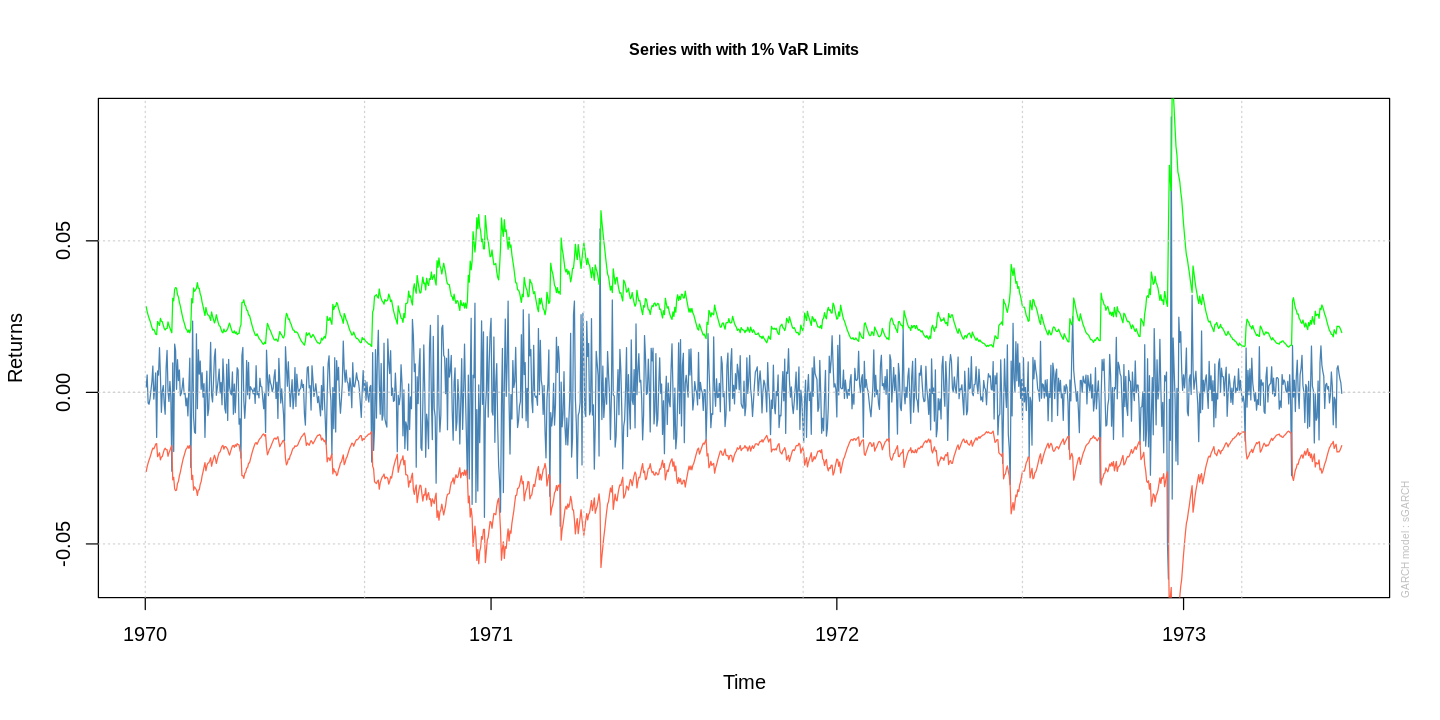

In [ ]:
# 1. ESTIMATION
garch_data <- analysis_df %>% filter(!is.na(ret))
spec <- ugarchspec(
  variance.model = list(model = "sGARCH", garchOrder = c(1, 1),
                        external.regressors = as.matrix(garch_data$sentiment_score)),
  mean.model = list(armaOrder = c(0, 0), include.mean = TRUE),
  distribution.model = "std"
)
fit <- ugarchfit(spec = spec, data = garch_data$ret)

# 2. OUTPUT PARAMETERS
# Note: While the Tone (vxreg1) is not a driver of variance magnitude,
# the persistence (beta1) remains the dominant factor, explaining ~86% of volatility clustering.
print(fit)

# 3. PLOT: CONDITIONAL VOLATILITY
options(repr.plot.width = 12, repr.plot.height = 6)
plot(fit, which = 2)

## 7. Initial Findings

The GARCH-X model provides critical insights into the efficiency of the **FED**'s communication channel:

1. **Volatility Persistence:** The $\beta_1$ coefficient ($\approx 0.86$) is highly significant ($p < 0.01$), confirming that volatility in the S&P 500 is "sticky"—once it enters a high-risk state, it remains there regardless of specific news.
2. **Statistical Insignificance of News:** The sentiment regressor (`vxreg1`) yielded a $p \approx 0.99$. In empirical finance, this suggests that the **FED**'s tone is an **anticipated signal**. The market prices in the **FED**'s trajectory via leading indicators (like CPI and Employment reports) before the statement is ever released.
3. **Information Effect Breakdown:** The 3-day window table shows that market returns often lead the **FED** announcement, indicating that the news is "baked into" prices during the $T-1$ anticipation period.

## 8. Theoretical Framework: Semi-Strong Form EMH

The statistical insignificance of the AI-derived **FED** tone ($p \approx 0.99$) is a significant empirical signal regarding market efficiency. According to the **Semi-Strong Form Efficient Market Hypothesis (EMH)**, stock prices reflect all publicly available information instantaneously.



Because the **FED** is highly transparent and data-dependent, institutional traders use economic indicators (CPI, Payrolls) to price in the "Tone" before the statement is ever released. By the time the statement reaches the public, the "Information Effect" has already occurred during the **Anticipation (T-1)** period. The $p \approx 0.99$ result confirms that the statement contains zero "surprise" component at the daily level.

## 9. Visualizing the Event Window Effect (T-1, T, T+1)

To visually validate the EMH finding, we aggregate returns across all 41 meetings. If the market is semi-strong efficient, the dispersion of returns on the **Event Day (T)** should not be significantly wider than the **Anticipation (T-1)** period, proving the market had already moved in preparation for the **FED** statement.

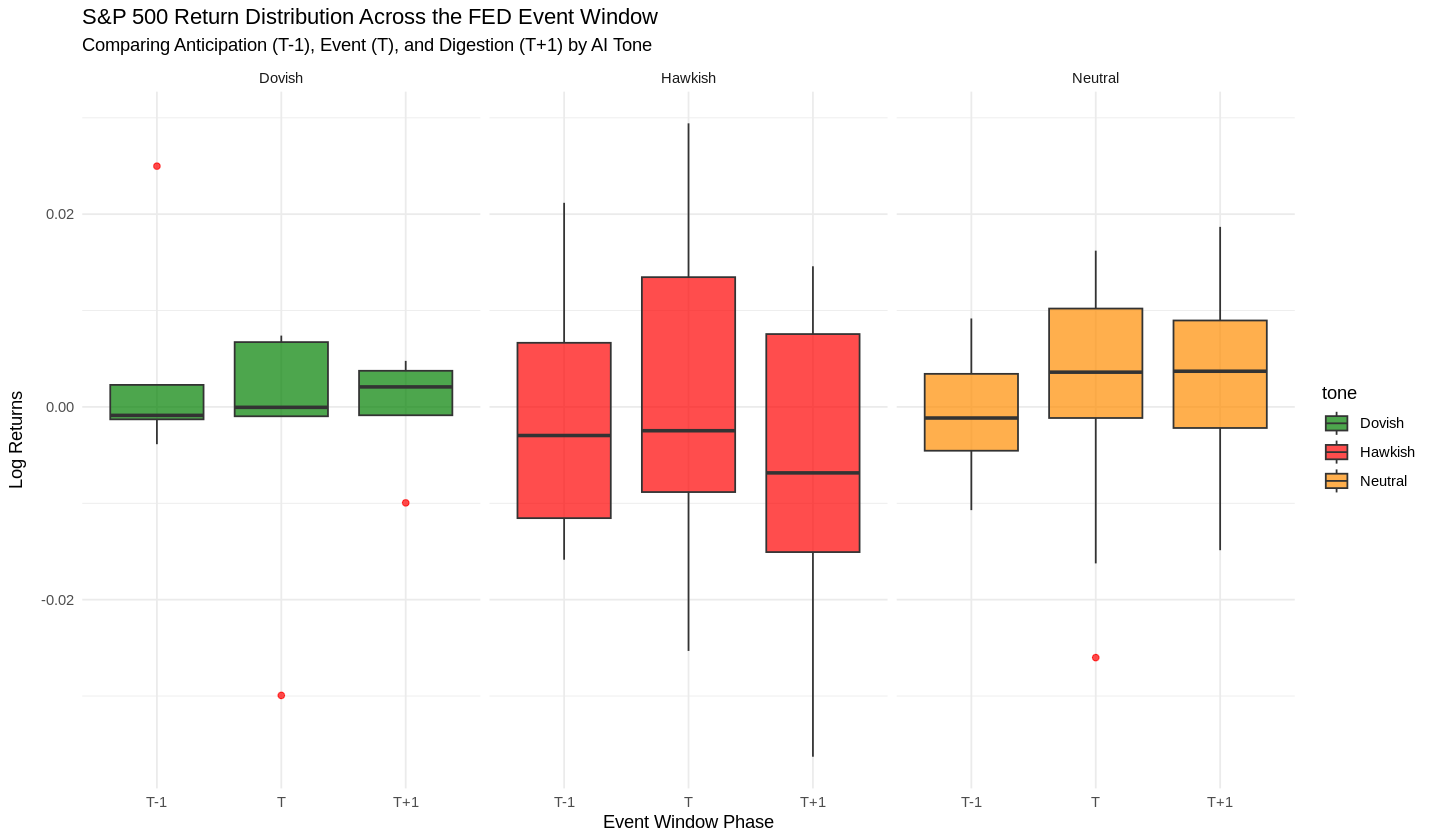

In [ ]:
# 1. RESTRUCTURE FOR EVENT PLOTTING
event_plot_df <- analysis_df %>%
  filter(is_fomc == 1) %>%
  select(date, tone, `T-1` = ret_prev, `T` = ret, `T+1` = ret_next) %>%
  pivot_longer(cols = c(`T-1`, `T`, `T+1`), names_to = "Window_Day", values_to = "Return") %>%
  mutate(Window_Day = factor(Window_Day, levels = c("T-1", "T", "T+1")))

# 2. GENERATE FACETED BOXPLOT
options(repr.plot.width = 12, repr.plot.height = 7)
ggplot(event_plot_df, aes(x = Window_Day, y = Return, fill = tone)) +
  geom_boxplot(alpha = 0.7, outlier.color = "red") +
  facet_wrap(~tone) +
  scale_fill_manual(values = c("Hawkish" = "#FF0000", "Dovish" = "#008000", "Neutral" = "#FF8C00")) +
  theme_minimal() +
  labs(title = "S&P 500 Return Distribution Across the FED Event Window",
       subtitle = "Comparing Anticipation (T-1), Event (T), and Digestion (T+1) by AI Tone",
       x = "Event Window Phase", y = "Log Returns")

## 10. Visualization: Overlaying AI Signal on Market Noise

Our second plot overlays the qualitative **Fedspeak** tone onto the quantitative S&P 500 returns, providing a visual narrative of the 2021–2025 policy cycle.

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


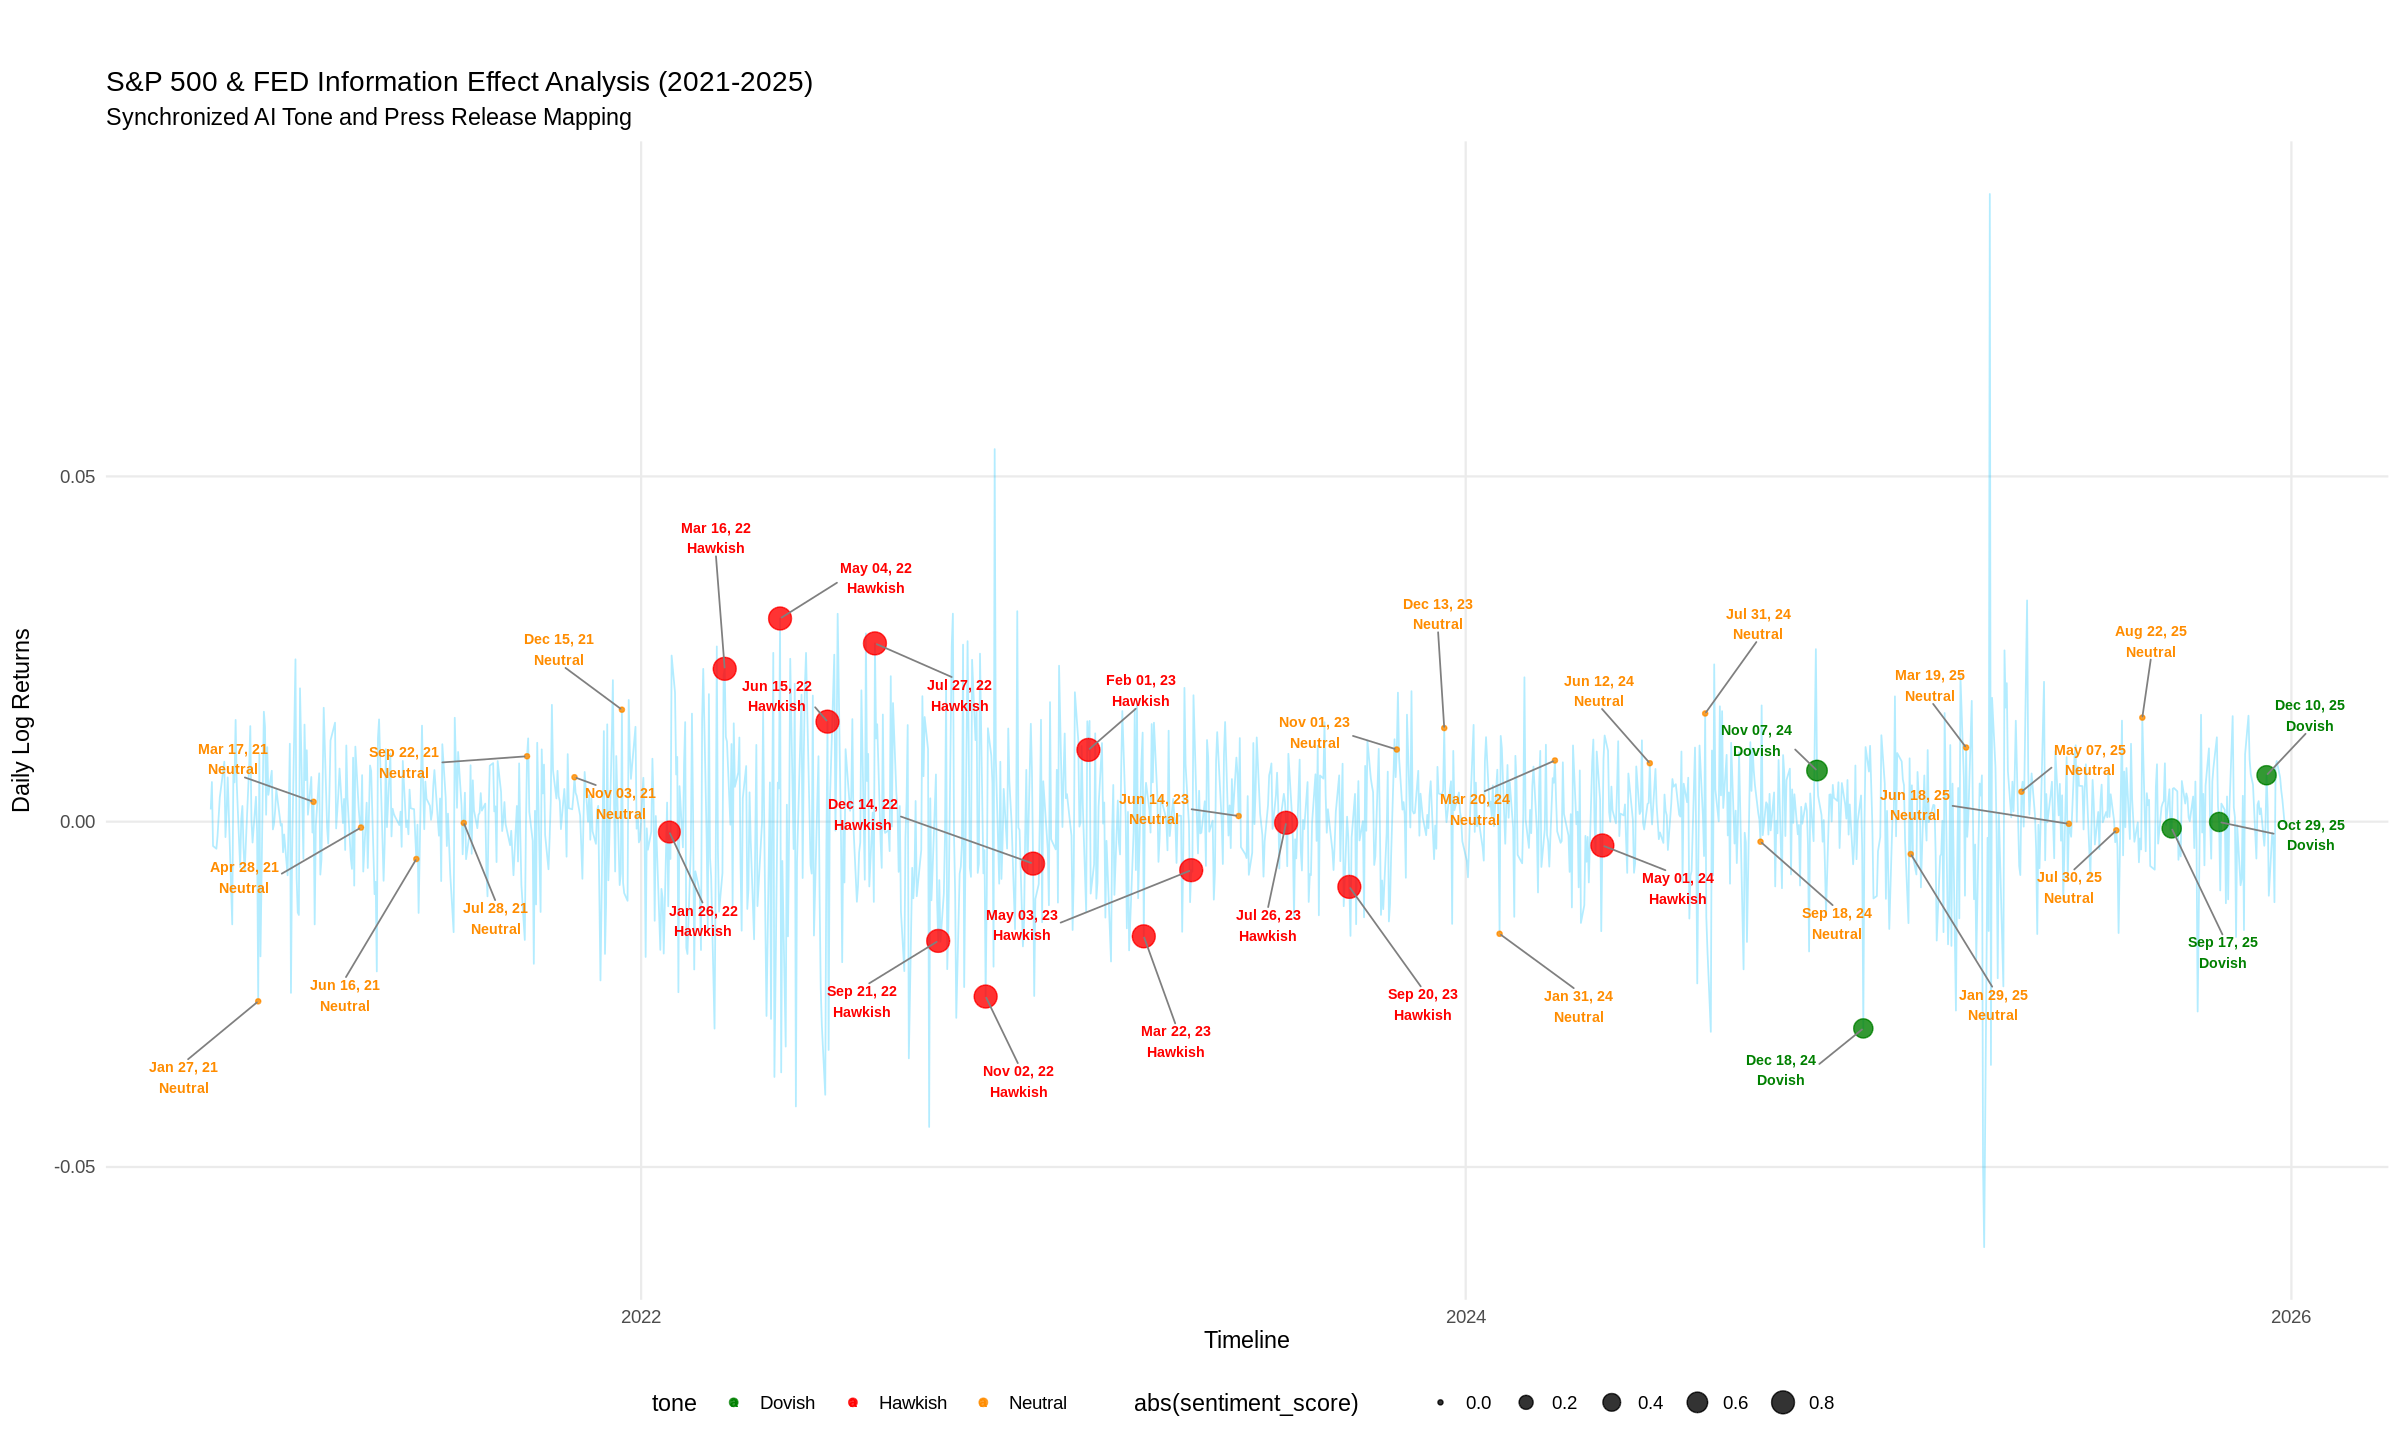

In [ ]:
# 1. LOAD REPEL & CONFIGURE OUTPUT
suppressPackageStartupMessages(library(ggrepel))
options(repr.plot.width = 20, repr.plot.height = 12)

# 2. GENERATE SYNCHRONIZED TIMELINE
ggplot(analysis_df, aes(x = date, y = ret)) +
  # Layer 1: Market Noise (Background)
  geom_line(color = "#00BFFF", alpha = 0.3, linewidth = 0.5) +
  # Layer 2: FED Meeting Points
  geom_point(data = subset(analysis_df, is_fomc == 1),
             aes(color = tone, size = abs(sentiment_score)), alpha = 0.8) +
  # Layer 3: Synchronized Text Labels
  geom_text_repel(aes(label = paste0(format(date, "%b %d, %y"), "\n", tone),
                      color = tone),
                  data = subset(analysis_df, is_fomc == 1),
                  size = 3.0, fontface = "bold", box.padding = 1.8,
                  force = 12, max.overlaps = Inf, segment.color = 'grey50',
                  min.segment.length = 0, direction = "both") +
  # Layer 4: Standardized Financial Color Logic
  scale_color_manual(values = c("Hawkish" = "#FF0000", # Red for Tightening
                              "Dovish" = "#008000", # Dark Green for Easing
                              "Neutral" = "#FF8C00")) + # Orange for Neutral
  # Layer 5: Styling
  theme_minimal(base_size = 14) +
  theme(legend.position = "bottom", panel.grid.minor = element_blank()) +
  labs(title = "\n\nS&P 500 & FED Information Effect Analysis (2021-2025)",
       subtitle = "Synchronized AI Tone and Press Release Mapping",
       x = "Timeline", y = "Daily Log Returns")

In [ ]:
# MEETING TEXT LOOKUP ONE LINER
# Change the date below to inspect the raw statement for any meeting on the plot
analysis_df %>% filter(date == as.Date("2024-05-01") & is_fomc == 1) %>% pull(full_text)

[1] "May 01, 2024 For release at 2:00 p.m. EDT Recent indicators suggest that economic activity has continued to expand at a solid pace. Job gains have remained strong, and the unemployment rate has remained low. Inflation has eased over the past year but remains elevated. In recent months, there has been a lack of further progress toward the Committee's 2 percent inflation objective. The Committee seeks to achieve maximum employment and inflation at the rate of 2 percent over the longer run. The Committee judges that the risks to achieving its employment and inflation goals have moved toward better balance over the past year. The economic outlook is uncertain, and the Committee remains highly attentive to inflation risks. In support of its goals, the Committee decided to maintain the target range for the federal funds rate at 5-1/4 to 5-1/2 percent. In considering any adjustments to the target range for the federal funds rate, the Committee will carefully assess incoming data, the evolving outlook, and the balance of risks. The Committee does not expect it will be appropriate to reduce the target range until it has gained greater confidence that inflation is moving sustainably toward 2 percent. In addition, the Committee will continue reducing its holdings of Treasury securities and agency debt and agency mortgage‑backed securities. Beginning in June, the Committee will slow the pace of decline of its securities holdings by reducing the monthly redemption cap on Treasury securities from $60 billion to $25 billion. The Committee will maintain the monthly redemption cap on agency debt and agency mortgage‑backed securities at $35 billion and will reinvest any principal payments in excess of this cap into Treasury securities. The Committee is strongly committed to returning inflation to its 2 percent objective. In assessing the appropriate stance of monetary policy, the Committee will continue to monitor the implications of incoming information for the economic outlook. The Committee would be prepared to adjust the stance of monetary policy as appropriate if risks emerge that could impede the attainment of the Committee's goals. The Committee's assessments will take into account a wide range of information, including readings on labor market conditions, inflation pressures and inflation expectations, and financial and international developments. Voting for the monetary policy action were Jerome H. Powell, Chair; John C. Williams, Vice Chair; Thomas I. Barkin; Michael S. Barr; Raphael W. Bostic; Michelle W. Bowman; Lisa D. Cook; Mary C. Daly; Philip N. Jefferson; Adriana D. Kugler; Loretta J. Mester; and Christopher J. Waller. For media inquiries, please email [email protected] or call 202-452-2955. Implementation Note issued May 1, 2024"

## 11. Synthesis and Overall Conclusion

### **Empirical Conclusions**
The research confirms that the market operates at a high level of Semi-Strong efficiency. The lack of statistical significance in the **FED** tone as a volatility driver suggests that **Fedspeak** serves as a confirmation of existing data rather than a primary source of news.

### **Future Work**
* **Intraday Tick Analysis:** Investigate if the "Information Effect" is concentrated in the first 15 minutes post-release.
* **Asymmetric Information:** Investigate whether **Hawkish** tones drive higher volatility than **Dovish** tones (Sign Bias Test). This would explore if the market reacts more violently to tightening threats than to easing promises.
* **Bond Market Sensitivity:** Extending this framework to the US Treasury market.

## 12. Dataset Export

To ensure reproducibility and facilitate future research, we export the final unified dataset containing S&P 500 returns, **FED** sentiment scores, and the 3-day event windows.

In [ ]:
# FINAL EXPORT
write.csv(analysis_df, "FED_Sentiment_Volatility_Data_2021_2025.csv", row.names = FALSE)
cat("Project Complete. Final dataset saved as: FED_Sentiment_Volatility_Data_2021_2025.csv\n")

Project Complete. Final dataset saved as: FED_Sentiment_Volatility_Data_2021_2025.csv
